In [1]:
# base
import pandas as pd
from pandas.api.types import CategoricalDtype, is_categorical_dtype
import numpy as np
import scanpy.api as sc
import scanpy.external
import anndata as ad
import scipy.stats as ss

#plotting
from plotnine import *
import plotnine
import matplotlib as mp
from adjustText import adjust_text


# ingest data and update labels
# adata = sc.read_h5ad('/mnt/ibm_lg/bingwu/AnnData/TA_COMET_1024Day0to16_MonoMac.h5ad')
# adata.obs['day'] = [int(x[3:]) for x in adata.obs['TACollectionDay']] 

def prepare_dataframe(adata, var_names, groupby=None, use_raw=None, log=False, num_categories=7):
    """
    ### FROM scanpy ###
    
    Given the anndata object, prepares a data frame in which the row index are the categories
    defined by group by and the columns correspond to var_names.
    Parameters
    ----------
    adata : :class:`~anndata.AnnData`
        Annotated data matrix.
    var_names : `str` or list of `str`
        `var_names` should be a valid subset of  `adata.var_names`.
    groupby : `str` or `None`, optional (default: `None`)
        The key of the observation grouping to consider. It is expected that
        groupby is a categorical. If groupby is not a categorical observation,
        it would be subdivided into `num_categories`.
    log : `bool`, optional (default: `False`)
        Use the log of the values
    use_raw : `bool`, optional (default: `None`)
        Use `raw` attribute of `adata` if present.
    num_categories : `int`, optional (default: `7`)
        Only used if groupby observation is not categorical. This value
        determines the number of groups into which the groupby observation
        should be subdivided.
    Returns
    -------
    Tuple of `pandas.DataFrame` and list of categories.
    """
    from scipy.sparse import issparse
#     sanitize_anndata(adata)
    if use_raw is None and adata.raw is not None: use_raw = True
    if isinstance(var_names, str):
        var_names = [var_names]

    if groupby is not None:
        if groupby not in adata.obs_keys():
            raise ValueError('groupby has to be a valid observation. Given value: {}, '
                             'valid observations: {}'.format(groupby, adata.obs_keys()))

    if use_raw:
        matrix = adata.raw[:, var_names].X
    else:
        matrix = adata[:, var_names].X

    if issparse(matrix):
        matrix = matrix.toarray()
    if log:
        matrix = np.log1p(matrix)

    obs_tidy = pd.DataFrame(matrix, columns=var_names)
    if groupby is None:
        groupby = ''
        categorical = pd.Series(np.repeat('', len(obs_tidy))).astype('category')
    else:
        if not is_categorical_dtype(adata.obs[groupby]):
            # if the groupby column is not categorical, turn it into one
            # by subdividing into  `num_categories` categories
            categorical = pd.cut(adata.obs[groupby], num_categories)
        else:
            categorical = adata.obs[groupby]

    obs_tidy.set_index(categorical, groupby, inplace=True)
    categories = obs_tidy.index.categories

    return categories, obs_tidy

def adata_DE_pairwise(input_adata, 
                      groupby, 
                      target_1, 
                      target_2, 
                      method = 'wilcoxon',
                      corr_method = 'benjamini-hochberg'
                     ):
    """
    Wrapper for scanpy DE tests. Two-sided.
    
    Input: adata, groupby variable, comparison labels, test, mutliple hypothesis procedure
    Output: dataframe of gene, log2fc, pval, adj_pval
    """
    
    n_genes=len(input_adata.var_names)
    sc.tl.rank_genes_groups(input_adata, 
                            groupby=groupby, 
                            groups=[target_1],
                            reference=target_2,
                            method=method,
                            n_genes = n_genes,
                            corr_method = corr_method
                           )
    genes = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]
    log2change = [x[0] for x in input_adata.uns['rank_genes_groups']['logfoldchanges']]
    pvals = [x[0] for x in input_adata.uns['rank_genes_groups']['pvals']]
    pvals_adj = [x[0] for x in input_adata.uns['rank_genes_groups']['pvals_adj']]
    
    results_df = pd.DataFrame({
        'gene':genes,
        'log2change':log2change,
        'pvals':pvals,
        'pvals_adj':pvals_adj
    })
    
    return results_df

def hmean(a):
    """
    harmonic mean
    ref = https://stackoverflow.com/questions/10712842/harmonic-mean-in-python
    
    """
    return len(a) / np.sum(1.0/a) 

/home/daniel_le/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [ ]:
# n_pcs = 200
# cluster_res = 1

# sc.tl.pca(adata,svd_solver='arpack', use_highly_variable = True, 
#           n_comps=n_pcs, random_state=1, zero_center = False)
# sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=15, random_state=1)
# sc.tl.leiden(adata, resolution = cluster_res, random_state=1)
# sc.tl.paga(adata, groups = 'leiden')
# sc.pl.paga(adata, colors=['leiden','day'])
# sc.tl.umap(adata, init_pos = 'paga')
# sc.pl.umap(adata, color = ['leiden','day'])


In [ ]:
# df = adata.obs.loc[:,['leiden','day']]

# plotnine.options.figure_size=(3,3)
# plot = (ggplot(df)
#         + theme_bw()
#         + geom_boxplot(aes('leiden','day'))
#        )
# print(plot)

# DE analysis

In [ ]:
# # adata.obs['de_groups'] = ['target' if x in ['3','4','5'] else 'rest' for x in adata.obs['leiden']]
# adata.obs['de_groups'] = ['target' if x >= 9 else 'rest' for x in adata.obs['day']]
# sc.pl.umap(adata, color = ['leiden','day','de_groups'])

# results_df = adata_DE_pairwise(adata, 
#                       'de_groups', 
#                       'target', 
#                       'rest', 
#                       method = 'wilcoxon',
#                       corr_method = 'benjamini-hochberg'
#                      )
# results_df = results_df.dropna()
# # log transform
# results_df['-log10_pvals_adj'] = [-np.log10(x) for x in results_df['pvals_adj']]
# # replace inf with machine precision
# results_df = results_df.replace(np.inf, np.nan)
# results_df = results_df.replace(np.nan, np.nanmax(results_df['-log10_pvals_adj'].values))
# # append top DE genes
# neg_geneset = (results_df[results_df['log2change'] < 0]
#                .sort_values('-log10_pvals_adj', ascending=False)
#                .gene.tolist()
#               )
# pos_geneset = (results_df[results_df['log2change'] > 0]
#                .sort_values('-log10_pvals_adj', ascending=False)
#                .gene.tolist()
#               )
# # add multitest cutoff
# alpha = 0.05
# threshold = -np.log10(alpha)

# # plot variables
# gene_n = 10
# results_df['GOI'] = [x in pos_geneset[:gene_n]+neg_geneset[:gene_n] for x in results_df.gene]

# # determine xlim
# xlim_df = results_df.sort_values(['-log10_pvals_adj'], ascending = False)
# xlim_df['rank'] = xlim_df['-log10_pvals_adj'].rank(pct = True)
# xlim_val = xlim_df[xlim_df['rank'] > 0.95]['log2change'].abs().max()

# plotnine.options.figure_size = (4,4)
# plot = (ggplot(results_df)
#         + theme_bw()
#         + theme(legend_position = 'none')
#         + geom_point(aes('log2change','-log10_pvals_adj'), alpha = 0.05)
#         + geom_text(results_df[results_df['GOI']==True], 
#                     aes('log2change','-log10_pvals_adj',label='gene'),
#                     size = 8)
#         + geom_point(results_df[results_df['GOI']==True], aes('log2change','-log10_pvals_adj'))
#         + geom_hline(aes(yintercept = threshold), linetype = '--', color = 'red')
#         + scale_x_continuous(limits=(-xlim_val,
#                                      xlim_val))
#        )
# f = plot.draw()
# for a in f.axes:
#     texts = [t for t in  a.texts]
#     adjust_text(texts,ax=a, arrowprops=dict(arrowstyle='-', color='#D3D3D3'),
#                 force_text=(0.1, 1),
# #                 force_points=(1, 1),
#                 expand_text=(1.3, 1.3),
# #                 expand_points=(2, 2)
#                )

## spearman coorelation

In [ ]:
# _,df = prepare_dataframe(adata,
#                          adata.var_names,
#                          'TACollectionDay'
#                         )
# hivar_genes = pd.DataFrame(adata.var.highly_variable).query('highly_variable == True').index.tolist()
# df = df.loc[:, hivar_genes]
# df['day']=[int(x[3:]) for x in df.index]

# pvals = []
# rhos = []
# day_arr = df['day'].values
# for gene in hivar_genes:
#     rho,pval = ss.spearmanr(day_arr, df[gene].values)
#     rhos.append(rho)
#     pvals.append(pval)
    
# results_df = pd.DataFrame({'gene':hivar_genes,
#                            'rho':rhos,
#                            'pval':pvals
#                           })
    

In [ ]:
# results_df.sort_values('rho')

## testing correlation over time

In [ ]:
# input_adata = adata
# _,df = prepare_dataframe(input_adata,
#                          input_adata.var_names,
#                          'TACollectionDay'
#                         )
# # df = df.rank(pct=True, axis=1)
# hivar_genes = (pd.DataFrame(input_adata
#                            .var
#                            .highly_variable)
#                .query('highly_variable == True')
#                .index
#                .tolist()
#               )
# df = df.loc[:, hivar_genes]
# df['day']=[int(x[3:]) for x in df.index]

# # create correlation matrix by day
# tstack = np.zeros((len(hivar_genes),len(hivar_genes),len(set(df['day']))))
# for idx,day in enumerate(set(df['day'])):
#     corr = (df
#                .query(f'day == {day}')
#                .drop('day', axis=1)
#                .corr()**2
#               )
#     corr = corr.replace(0,0.000001)
#     tstack[:,:,idx] =np.array(corr)

# # stack and compute harmonic mean
# tstack_hmean = np.apply_along_axis(hmean, 2, tstack)
# tstack_hmean_triu = np.triu(tstack_hmean, k=1)
# tstack_hmean_triu[tstack_hmean_triu == 0] = np.nan
# tstack_df = pd.DataFrame(tstack_hmean_triu)
# tstack_df.columns = corr.columns
# tstack_df['gene'] = corr.columns
# tstack_melt = (pd.melt(tstack_df, id_vars='gene')
#                .dropna()
#                .sort_values('value', ascending = False)
#               )

In [ ]:
# # output top correlated gene pairs
# tstack_melt_slice = tstack_melt.head(100)

# # create contig networks
# cluster_lists = []
# pair_list = [(x,y) for x,y in zip(tstack_melt_slice['gene'], tstack_melt_slice['variable'])]
# possible_genes = [ele for sublist in pair_list for ele in sublist]
# possible_genes = list(set(possible_genes))

# # testing
# # pair_list = [['a','b'], ['a','c'], ['d','e'],['c','a']]
# # possible_genes = [ele for sublist in pair_list for ele in sublist]

# for key in possible_genes:
#     contig_cluster = [key]
#     current_step = contig_cluster
#     # step1: look for partners
#     if len(current_step) > 0:
#         next_step = []
#         for x in current_step:
#             match_list = [sublist for sublist in pair_list if x in sublist]
#             match_list = [ele for sublist in match_list for ele in sublist]
#             for y in match_list:
#                 if y not in contig_cluster:
#                     contig_cluster.append(y)
#                     next_step.append(y)
                
#         current_step = next_step

#     cluster_lists.append(frozenset(contig_cluster))

# cluster_lists = [list(x) for x in set(cluster_lists)]

In [ ]:
# for idx,x in enumerate(cluster_lists):
#     print(idx, x)
#     plot_df = (df
#                .loc[:,cluster_lists[idx]+['day']]
#                .reset_index()
#                .groupby('day')
#                .mean()
#                .reset_index()
#               )
#     plot_df = pd.melt(plot_df, id_vars = 'day')

#     plotnine.options.figure_size = (3,3)
#     plot = (ggplot(plot_df)
#             + theme_bw()
#             + geom_line(aes('day','value',color='variable'))
#            )
#     print(plot)        

In [ ]:
# _,df = prepare_dataframe(adata,
#                          adata.var_names,
#                          'TACollectionDay'
#                         )
# # df = df.rank(pct=True, axis=1)
# df['n_genes'] = adata.obs['n_genes'].tolist()
# df['n_genes_by_counts'] = adata.obs['n_genes_by_counts'].tolist()
# hivar_genes = pd.DataFrame(adata.var.highly_variable).query('highly_variable == True').index.tolist()
# df = df.loc[:, hivar_genes+['n_genes','n_genes_by_counts']]
# df['day']=[int(x[3:]) for x in df.index]

In [ ]:
# plot_df = (df
#            .loc[:,['n_genes','day']]
#            .reset_index()
#            .groupby('day')
#            .mean()
#            .reset_index()
#           )
# plot_df = pd.melt(plot_df, id_vars = 'day')

# plotnine.options.figure_size = (3,3)
# plot = (ggplot(plot_df)
#         + theme_bw()
#         + geom_line(aes('day','value',color='variable'))
#        )
# print(plot)        

## create new time-series data

In [ ]:
# patient_id = 1031
# marker = 'CD45'

# for day in [0,2,6,7,8]:
#     if day == 0:
#         adata_long = sc.read_10x_mtx(f'/mnt/ibm_lg/daniel_le/data/covid/comet/raw_10x/COMET_1031_CD45_day{day}/')
#         adata_long.obs['day'] = day
#         adata_long.obs['patient_id'] = patient_id
#         adata_long.obs['marker'] = marker
#     else:
#         adata_slice = sc.read_10x_mtx(f'/mnt/ibm_lg/daniel_le/data/covid/comet/raw_10x/COMET_1031_CD45_day{day}/')
#         adata_slice.obs['day'] = day
#         adata_slice.obs['patient_id'] = patient_id
#         adata_slice.obs['marker'] = marker
#         adata_long = adata_long.concatenate(adata_slice)
    
# sc.pp.calculate_qc_metrics(adata_long, inplace=True)
# sc.pp.filter_genes(adata_long, min_cells=1)
# ribo_genes = adata_long.var_names.str.startswith(('RPS','RPL'))
# adata_long.obs['percent_ribo'] = np.sum(adata_long[:, ribo_genes].X, axis=1).A1 / np.sum(adata_long.X, axis=1).A1
# mito_genes = adata_long.var_names.str.startswith(('MT-'))
# adata_long.obs['percent_mito'] = np.sum(adata_long[:, mito_genes].X, axis=1).A1 / np.sum(adata_long.X, axis=1).A1
# sc.pp.normalize_total(adata_long, target_sum=1e4)
# sc.pp.log1p(adata_long)
# adata_long.raw = adata_long
# sc.pp.scale(adata_long, max_value=4)
# adata_long.obs['cell_id'] = adata_long.obs.index.values
# sc.pp.highly_variable_genes(adata_long, 
#                             min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata_long.write('/mnt/ibm_lg/daniel_le/data/covid/comet/comet_1031_CD45_long.h5ad')

In [ ]:
# input_adata = adata_long
# _,df = prepare_dataframe(input_adata,
#                          input_adata.var_names,
#                          'batch'
#                         )
# hivar_genes = (pd.DataFrame(input_adata
#                            .var
#                            .highly_variable)
#                .query('highly_variable == True')
#                .index
#                .tolist()
#               )
# df = df.loc[:, hivar_genes]
# df['day'] = input_adata.obs['day'].values

# # create correlation matrix by day
# tstack = np.zeros((len(hivar_genes),len(hivar_genes),len(set(df['day']))))
# for idx,day in enumerate(set(df['day'])):
#     corr = (df
#                .query(f'day == {day}')
#                .drop('day', axis=1)
#                .corr()**2
#               )
#     corr = corr.replace(0,0.000001)
#     tstack[:,:,idx] =np.array(corr)

# # stack and compute harmonic mean
# tstack_hmean = np.apply_along_axis(hmean, 2, tstack)
# tstack_hmean_triu = np.triu(tstack_hmean, k=1)
# tstack_hmean_triu[tstack_hmean_triu == 0] = np.nan
# tstack_df = pd.DataFrame(tstack_hmean_triu)
# tstack_df.columns = corr.columns
# tstack_df['gene'] = corr.columns
# tstack_melt = (pd.melt(tstack_df, id_vars='gene')
#                .dropna()
#                .sort_values('value', ascending = False)
#               )

In [ ]:
# # output top correlated gene pairs
# tstack_melt_slice = tstack_melt.head(300)

# # create contig networks
# cluster_lists = []
# pair_list = [(x,y) for x,y in zip(tstack_melt_slice['gene'], tstack_melt_slice['variable'])]
# possible_genes = [ele for sublist in pair_list for ele in sublist]
# possible_genes = list(set(possible_genes))

# # testing
# # pair_list = [['a','b'], ['a','c'], ['d','e'],['c','a']]
# # possible_genes = [ele for sublist in pair_list for ele in sublist]

# for key in possible_genes:
#     contig_cluster = [key]
#     current_step = contig_cluster
#     # step1: look for partners
#     if len(current_step) > 0:
#         next_step = []
#         for x in current_step:
#             match_list = [sublist for sublist in pair_list if x in sublist]
#             match_list = [ele for sublist in match_list for ele in sublist]
#             for y in match_list:
#                 if y not in contig_cluster:
#                     contig_cluster.append(y)
#                     next_step.append(y)
                
#         current_step = next_step

#     cluster_lists.append(frozenset(contig_cluster))

# cluster_lists = [list(x) for x in set(cluster_lists)]

In [ ]:
# for idx,x in enumerate(cluster_lists):
#     print(idx, x)
#     plot_df = (df
#                .loc[:,cluster_lists[idx]+['day']]
#                .groupby('day')
#                .mean()
#                .reset_index()
#               )
#     plot_df = pd.melt(plot_df, id_vars = 'day')

#     plotnine.options.figure_size = (3,3)
#     plot = (ggplot(plot_df)
#             + theme_bw()
#             + geom_line(aes('day','value',color='variable'))
#            )
#     print(plot)        

In [ ]:
# _,df = prepare_dataframe(adata_long,
#                          adata_long.var_names,
#                          'batch'
#                         )
# df['n_genes_by_counts'] = adata_long.obs['n_genes_by_counts'].tolist()
# df['day'] = adata_long.obs['day'].tolist()

# hivar_genes = pd.DataFrame(adata_long.var.highly_variable).query('highly_variable == True').index.tolist()
# df = df.loc[:, hivar_genes+['day','n_genes_by_counts']]

In [ ]:
# plot_df = (df
#            .loc[:,['n_genes_by_counts','day']]
#            .reset_index()
#            .groupby('day')
#            .mean()
#            .reset_index()
#           )
# plot_df = pd.melt(plot_df, id_vars = 'day')

# plotnine.options.figure_size = (3,3)
# plot = (ggplot(plot_df)
#         + theme_bw()
#         + geom_line(aes('day','value',color='variable'))
#        )
# print(plot)        

# full time-series data

In [40]:
adata = sc.read_h5ad('/mnt/ibm_lg/ashleyb/COVID19_Data/COMET/COMET_Analysis/AnnData/AnnData_June12_Annotated.h5ad')
adata.obs['day'] = [int(x.strip()[3:]) for x in adata.obs['TACollectionDay']]

In [41]:
processed_meta = (adata
                 .obs
                 .loc[:,['patientID_415-xxxx',
                         'cell_type_AllLeiden06',
                         'SARS_CoV2_qPCR',
                         'day'
                        ]]
                 .drop_duplicates()
                )
processed_meta

,patientID_415-xxxx,cell_type_AllLeiden06,SARS_CoV2_qPCR,day
AAACCTGAGAAGGTTT-1-0,1031,Mono/Macro,Positive,14
AAACCTGAGCTAAACA-1-0,1031,B,Positive,14
AAAGTAGTCAGAGACG-1-0,1031,Neutrophil,Positive,14
AAAGTAGTCCGGCACA-1-0,1031,Ciliated,Positive,14
AACCATGTCCACGAAT-1-0,1031,T/NK,Positive,14
...,...,...,...,...
AAACCTGTCGAGAGCA-1-51,1047,Neutrophil,Positive,2
AAGACCTAGTGAATTG-1-51,1047,T/NK,Positive,2
AGCATACTCTGGTGTA-1-51,1047,B,Positive,2
AGCGGTCCAGGAATCG-1-51,1047,Secretory,Positive,2


In [43]:
# update relative time

endpoints_df = (pd.DataFrame(processed_meta
                .groupby('patientID_415-xxxx')['day']
                .value_counts()
               )
                .drop('day', axis=1)
                .reset_index()
                .sort_values(['patientID_415-xxxx','day'])
               )
endpoints_df['index'] = endpoints_df.groupby('patientID_415-xxxx')['day'].rank().astype(int)
endpoints_df = endpoints_df.rename(columns = {'patientID_415-xxxx':'patient'})

index_dict = {}

for i in set(endpoints_df['patient']):
    df_slice = endpoints_df[endpoints_df['patient'] == i]
    max_val = np.nan
    nearmax_val = np.nan
    nearmin_val = np.nan
    min_val = np.nan
        
    if len(df_slice) == 1:
        pass
    elif len(df_slice) == 2:
        max_val = df_slice[df_slice['index'] == 2]['day'].values[0]
        min_val = df_slice[df_slice['index'] == 1]['day'].values[0]
    elif len(df_slice) == 3:
        max_val = df_slice[df_slice['index'] == 3]['day'].values[0]
        min_val = df_slice[df_slice['index'] == 1]['day'].values[0]
    elif len(df_slice) == 4:
        max_val = df_slice[df_slice['index'] == 4]['day'].values[0]
        nearmax_val = df_slice[df_slice['index'] == 3]['day'].values[0]
        nearmin_val = df_slice[df_slice['index'] == 2]['day'].values[0]
        min_val = df_slice[df_slice['index'] == 1]['day'].values[0]
    elif len(df_slice) >= 5:
        max_val = df_slice[df_slice['index'] == max(df_slice['index'])]['day'].values[0]
        nearmax_val = df_slice[df_slice['index'] == max(df_slice['index'])-1]['day'].values[0]
        nearmin_val = df_slice[df_slice['index'] == min(df_slice['index'])+1]['day'].values[0]
        min_val = df_slice[df_slice['index'] == min(df_slice['index'])]['day'].values[0]
        
    index_dict[i] = [max_val, nearmax_val, nearmin_val, min_val]

adata.obs['endpoint'] = ['max' if index_dict.get(x)[0] == y \
                     else 'nearmax' if index_dict.get(x)[1] == y \
                     else 'nearmin' if index_dict.get(x)[2] == y \
                     else 'min' if index_dict.get(x)[3] == y \
                     else 'None' \
                     for x,y in zip(adata.obs['patientID_415-xxxx'],adata.obs['day'])]
adata.obs['binned_time'] = ['end' if x in ['max','nearmax'] \
                            else 'start' if x in ['min','nearmin'] \
                            else 'mid' if x == 'None' \
                            else 'None' \
                            for x in adata.obs['endpoint']]

In [ ]:
# classifier_genes = DEG_df[[x > 0.05 for x in DEG_df[('-log10_pvals_adj','min')]]].index.tolist()

# cell_type = 'Mono/Macro'
# cell_type_title = 'cell_type_AllLeiden06'
# covid_status_title = 'SARS_CoV2_qPCR'
# endpoint_title = 'endpoint'

# input_adata = adata[adata.obs[cell_type_title] == cell_type]
# input_adata = input_adata[input_adata.obs[covid_status_title] == 'Positive']

# results_df = adata_DE_pairwise(input_adata, 
#                                endpoint_title, 
#                               'max', 
#                               'min', 
#                              )
# results_df = results_df.dropna()
# # log transform
# results_df['-log10_pvals_adj'] = [-np.log10(x) for x in results_df['pvals_adj']]
# # replace inf with machine precision
# results_df = results_df.replace(np.inf, np.nan)
# results_df = results_df.replace(np.nan, np.nanmax(results_df['-log10_pvals_adj'].values))
# # add multitest cutoff
# alpha = 0.05
# threshold = -np.log10(alpha)
# # plot variables
# results_df['GOI'] = [x in classifier_genes for x in results_df['gene']]
# # determine xlim
# xlim_df = results_df.sort_values(['-log10_pvals_adj'], ascending = False)
# xlim_df['rank'] = xlim_df['-log10_pvals_adj'].rank(pct = True)
# xlim_val = xlim_df[xlim_df['rank'] > 0.95]['log2change'].abs().max()

# plotnine.options.figure_size = (4,4)
# plot = (ggplot(results_df)
#         + theme_bw()
#         + theme(legend_position = 'none')
#         + geom_point(aes('log2change','-log10_pvals_adj'), alpha = 0.05)
# #         + geom_text(results_df[results_df['GOI']==True], 
# #                     aes('log2change','-log10_pvals_adj',label='gene'),
# #                     color='red',
# #                    size = 8)
#         + geom_point(results_df[results_df['GOI']==True], 
#                      aes('log2change','-log10_pvals_adj'),
#                      color='red',
#                     )
#         + geom_hline(aes(yintercept = threshold), linetype = '--', color = 'red')
#         + scale_x_continuous(limits=(-xlim_val,
#                                      xlim_val))
#         + ggtitle(cell_type)
#        )
# f = plot.draw()
# for a in f.axes:
#     texts = [t for t in  a.texts]
#     adjust_text(texts,ax=a, arrowprops=dict(arrowstyle='-', color='red'),
#                 force_text=(0.1, 1),
# #                 force_points=(1, 1),
#                 expand_text=(1.3, 1.3),
# #                 expand_points=(2, 2)
#                )

In [21]:
cell_type = 'Mono/Macro'
cell_type_title = 'cell_type_AllLeiden06'
covid_status_title = 'SARS_CoV2_qPCR'
endpoint_title = 'binned_time'
patient_id_title = 'patientID_415-xxxx'

compiled_df = pd.DataFrame()
for patient_id in set(adata[adata.obs[covid_status_title] == 'Positive'].obs[patient_id_title]):
    input_adata = adata[adata.obs[cell_type_title] == cell_type]
    input_adata = input_adata[input_adata.obs[patient_id_title] == patient_id]
    try:
        results_df = adata_DE_pairwise(input_adata, 
                                       endpoint_title, 
                                      'end', 
                                      'start', 
                                     )
        results_df = results_df.dropna()
        # log transform
        results_df['-log10_pvals_adj'] = [-np.log10(x) for x in results_df['pvals_adj']]
        # replace inf with machine precision
        results_df = results_df.replace(np.inf, np.nan)
        results_df = results_df.replace(np.nan, np.nanmax(results_df['-log10_pvals_adj'].values))
        results_df = results_df.loc[:,['gene','log2change','-log10_pvals_adj']]
        results_df = results_df[[x in adata.var_names[adata.var['highly_variable'].tolist()].tolist() for x in results_df['gene']]]
        results_df['drop_patient'] = patient_id
        compiled_df = compiled_df.append(results_df)
    except Exception as e:
        print(e)
        
DEG_df = (compiled_df
             .drop('drop_patient', axis=1)
             .groupby('gene')
             .describe()
          .sort_values(('-log10_pvals_adj','50%'))
            )


/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'endpoint' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'binned_time' as categorical
/home/daniel_le/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'endpoint' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'binned_time' as categorical
/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificatio

reference = start needs to be one of groupby = ['None'].


... storing 'endpoint' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'binned_time' as categorical
/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'endpoint' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'binned_time' as categorical
/home/daniel_le/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'endpoint' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'binn

reference = start needs to be one of groupby = ['None'].


Trying to set attribute `.obs` of view, copying.
... storing 'endpoint' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'binned_time' as categorical


reference = start needs to be one of groupby = ['None'].


Trying to set attribute `.obs` of view, copying.
... storing 'endpoint' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'binned_time' as categorical
/home/daniel_le/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'endpoint' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'binned_time' as categorical
/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'endpoint' as categorical
Trying to set att

reference = start needs to be one of groupby = ['None'].


In [60]:
DEG_df[[x > 0.05 for x in DEG_df[('-log10_pvals_adj','min')]]] .sort_values(('-log10_pvals_adj','50%'), ascending=False).index.values

array(['CCL4L2', 'CCL4', 'CTSD', 'CCL3L1', 'FABP5', 'ACP5', 'CTSL',
       'IFI30', 'HMOX1', 'CRIP1', 'MT-CO3', 'HSP90AA1', 'NEAT1', 'GSTP1',
       'HLA-DRA', 'S100A10', 'HSPB1', 'PI3', 'LYZ', 'APOE', 'TIMP1',
       'CD74', 'APOC1', 'GLUL', 'LST1', 'HSPA5', 'CD163', 'MT-ATP8',
       'S100A8', 'RNASE1', 'IER2', 'C1QB', 'VAMP5', 'MT2A', 'PECAM1',
       'TNFSF13B', 'S100A12', 'KCTD12', 'MT-CO1', 'C1QA', 'JUN', 'SGK1',
       'MITF', 'HSD3B7', 'CTDNEP1', 'IFI27', 'CHD9', 'TPST2', 'AGAP3',
       'ZSCAN16-AS1', 'PRCP', 'EEA1', 'ACSL1', 'FOXN2'], dtype=object)

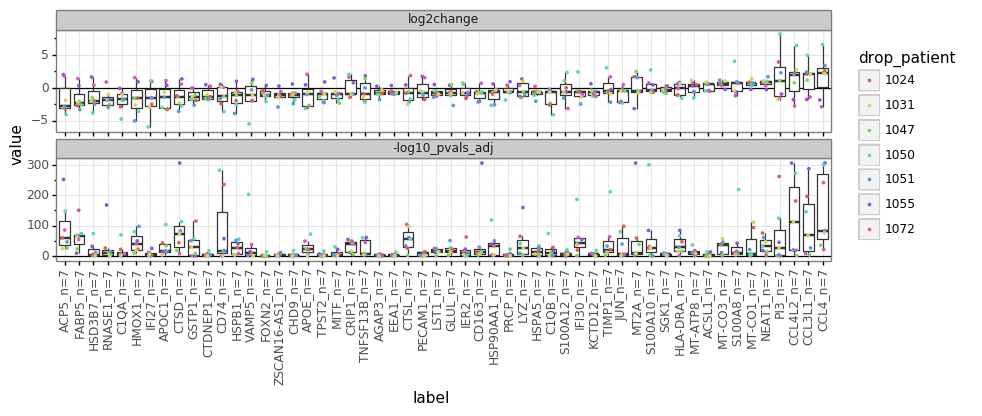

<ggplot: (8792429423161)>


log2change                               -log10_pvals_adj  \
                     count       50%       min       max            count   
label                                                                       
EEA1_n=7               7.0 -0.870064 -0.995921  0.328008              7.0   
CTDNEP1_n=7            7.0 -1.346816 -1.790984  0.460009              7.0   
GSTP1_n=7              7.0 -1.355927 -2.656596 -0.056033              7.0   
RNASE1_n=7             7.0 -1.916356 -3.009933  0.851823              7.0   
FABP5_n=7              7.0 -2.272702 -3.336776  1.381415              7.0   
ACP5_n=7               7.0 -2.818857 -4.078527  1.984407              7.0   
NEAT1_n=7              7.0  0.916197 -0.299606  1.677664              7.0   
FOXN2_n=7              7.0 -1.109662 -2.105946  0.343592              7.0   
MT-CO3_n=7             7.0  0.631964 -0.275154  1.132222              7.0   
AGAP3_n=7              7.0 -0.871266 -1.830911  0.220231              7.0   
MT-CO1_n=7             7.0  0.669334 -0.263631  1.333340              7.0   
LST1_n=7               7.0 -0.801421 -1.466379  0.475386              7.0   
C1QA_n=7               7.0 -1.783240 -4.771152 -0.123766              7.0   
ACSL1_n=7              7.0  0.512062 -0.530903  0.842807              7.0   
HSD3B7_n=7             7.0 -2.010166 -3.846902  1.618287              7.0   
CHD9_n=7               7.0 -1.060199 -2.440531  0.558866              7.0   
ZSCAN16-AS1_n=7        7.0 -1.098655 -2.933381  0.244027              7.0   
APOC1_n=7              7.0 -1.467079 -3.337945  1.073488              7.0   
CD74_n=7               7.0 -1.335157 -3.632468  0.484727              7.0   
IER2_n=7               7.0 -0.742426 -1.633079  0.706324              7.0   
SGK1_n=7               7.0 -0.361277 -0.891492  0.252318              7.0   
KCTD12_n=7             7.0 -0.599201 -1.339136  0.591554              7.0   
TPST2_n=7              7.0 -0.972560 -2.269256  0.870216              7.0   
CCL3L1_n=7             7.0  2.051773 -1.782835  4.914250              7.0   
HSPA5_n=7              7.0 -0.670167 -2.053395  0.209703              7.0   
CTSD_n=7               7.0 -1.379851 -3.601599  1.326077              7.0   
CRIP1_n=7              7.0 -0.935620 -1.477347  2.028033              7.0   
CD163_n=7              7.0 -0.736754 -2.153927  0.661546              7.0   
GLUL_n=7               7.0 -0.782571 -2.699097  0.412999              7.0   
HMOX1_n=7              7.0 -1.632015 -5.047216  1.523050              7.0   
MITF_n=7               7.0 -0.951512 -2.360546  1.477754              7.0   
PRCP_n=7               7.0 -0.680733 -1.862820  0.917738              7.0   
CCL4_n=7               7.0  2.290730 -2.912771  6.557890              7.0   
LYZ_n=7                7.0 -0.679226 -1.502429  1.318646              7.0   
HSPB1_n=7              7.0 -1.174927 -3.926546  0.969380              7.0   
PECAM1_n=7             7.0 -0.810161 -1.810842  1.697119              7.0   
TNFSF13B_n=7           7.0 -0.914782 -2.186078  1.795542              7.0   
IFI27_n=7              7.0 -1.581386 -5.968979  1.040257              7.0   
HSP90AA1_n=7           7.0 -0.719018 -2.696113  0.563580              7.0   
CCL4L2_n=7             7.0  1.993171 -2.781214  6.394468              7.0   
APOE_n=7               7.0 -1.027794 -3.160012  2.037452              7.0   
CTSL_n=7               7.0 -0.814530 -2.494691  1.831313              7.0   
JUN_n=7                7.0 -0.494501 -2.343235  0.456523              7.0   
C1QB_n=7               7.0 -0.659668 -4.121017 -0.228225              7.0   
VAMP5_n=7              7.0 -1.122436 -5.501790  1.269429              7.0   
IFI30_n=7              7.0 -0.631199 -2.482965  2.402045              7.0   
S100A8_n=7             7.0  0.664934 -1.207346  4.014492              7.0   
S100A12_n=7            7.0 -0.647745 -3.171654  2.309650              7.0   
S100A10_n=7            7.0 -0.398134 -0.767403  2.689523              7.0   
PI3_n=7     

In [23]:
classifier_genes = DEG_df[[x > 0.05 for x in DEG_df[('-log10_pvals_adj','min')]]].index.tolist()

plot_df = pd.melt(compiled_df[[x in classifier_genes for x in compiled_df.gene]], id_vars=['gene','drop_patient'])
plot_df['variable'] = (plot_df['variable']
                       .astype(str)
                       .astype(CategoricalDtype(['log2change','-log10_pvals_adj'],
                                                ordered = True
                                               ))
                      )

# add covid status
covid_color = (adata
               .obs
               .loc[:,[patient_id_title, covid_status_title]]
               .drop_duplicates()
               .rename(columns={patient_id_title:'drop_patient',
                                covid_status_title:'covid'
                               })
              )
plot_df = (pd
           .merge(plot_df, covid_color, 'left', 'drop_patient')
          )

# add sample n
stat_df = (compiled_df[[x in classifier_genes for x in compiled_df.gene]]
             .drop('drop_patient', axis=1)
             .groupby('gene')
             .describe()
             .loc[:,[('log2change','count'),
                     ('log2change','50%'),
                     ('log2change','min'),
                     ('log2change','max'),
                     ('-log10_pvals_adj','count'),
                     ('-log10_pvals_adj','50%'),
                     ('-log10_pvals_adj','min'),
                     ('-log10_pvals_adj','max'),
                    ]]
            )
stat_df[('log2change','range')] = abs(stat_df[('log2change','max')]-stat_df[('log2change','min')])
stat_df[('log2change','CRV')] = abs(stat_df[('log2change','range')]/stat_df[('log2change','50%')])
stat_df['label'] = [f'{x}_n={int(y)}' for x,y in zip(stat_df.index, stat_df[('log2change','count')])]
stat_df = stat_df.sort_values(('log2change','CRV'), ascending=True)
count_df = (pd.DataFrame(stat_df.loc[:,('log2change','count')])
            .astype(int)
            .reset_index()
           )
count_df['label'] = [f'{x}_n={y}' for x,y in zip(count_df['gene'],count_df[('log2change','count')])]
count_df = count_df.loc[:,['gene','label']]
count_df.columns = ['gene','label']
plot_df = pd.merge(plot_df, count_df, 'left', 'gene')

# add summaries
rect_df = plot_df.groupby(['label','variable']).describe()
rect_df.columns = (rect_df
                    .columns.get_level_values(1)
                   )
rect_df = rect_df.reset_index()

# reorder labels
plot_df['label'] = (plot_df['label']
                    .astype(str)
                    .astype(CategoricalDtype(rect_df.query('variable == "log2change"').sort_values('50%')['label'].tolist(),ordered=True))
                   )

plotnine.options.figure_size = (10,3)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle=90),
                panel_spacing_x = 0.3
               )
        + geom_hline(aes(yintercept=0))
        + geom_boxplot(aes('label','value'),
                     outlier_alpha=0)
        + geom_jitter(aes('label','value', color='drop_patient'),
                     size=0.5, width=0.2)
        + facet_wrap('~variable', scales = 'free', ncol=1)
       )
print(plot)

display(stat_df.set_index('label'))

In [24]:
# volcano_df = (pd.DataFrame(pd.DataFrame(plot_df.groupby(['label','variable'])['value'].median())
#                          .reset_index()
#                          .pivot(index='label', columns='variable', values='value')
#                           )
#              )
# label_order = volcano_df.index.tolist()
# volcano_df.columns =volcano_df.columns.astype(list)
# volcano_df = volcano_df.reset_index()
# volcano_df

# plotnine.options.figure_size = (3,3)
# plot = (ggplot(volcano_df)
#         + theme_bw()
#         + theme(aspect_ratio=1)
#         + geom_point(aes('log2change','-log10_pvals_adj',color='label'))
#        )
# print(plot)

In [25]:
# from scipy.stats import iqr
# iqr_df = (pd.DataFrame(pd.DataFrame(plot_df.groupby(['label','variable'])['value'].apply(iqr)
#                          .reset_index()
#                          .pivot(index='label', columns='variable', values='value')
#                           )
#              )
#          )
# iqr_df.columns = iqr_df.columns.astype(list)
# iqr_df = iqr_df.reset_index()
# iqr_df['label'] = (iqr_df['label']
#                    .astype(str)
#                    .astype(CategoricalDtype(label_order, ordered = True))
#                   )

# plotnine.options.figure_size = (6,3)
# plot = (ggplot(iqr_df)
#         + theme_bw()
#         + theme(
#                 axis_text_x = element_text(angle=90)
#                )
#         + geom_bar(aes('label','log2change'), stat='identity')
#         + ylab('IQR')
#         + xlab('')
#        )
# print(plot)

In [26]:
# pivot_counts = (adata
#                  .obs
#                  .loc[:,['patientID_415-xxxx',
#                          'cell_type_AllLeiden06',
#                          'SARS_CoV2_qPCR',
#                          'day',
#                          'endpoint'
#                         ]]
#                 )
# (pd.DataFrame(pivot_counts
#  .query(f'{cell_type_title}=="{cell_type}"')
#  .query('SARS_CoV2_qPCR=="Positive"')
#  .groupby(['patientID_415-xxxx','endpoint'])
#  .size()
# ).rename(columns={0:'count'})
#  .reset_index()
#  .query('endpoint != "internal"')
#  .pivot(index='patientID_415-xxxx', columns='endpoint', values='count')
# )

### plot trends

In [45]:
input_adata = adata[adata.obs[covid_status_title] == 'Positive']
_,df = prepare_dataframe(input_adata,
                         ['CCL4'],
#                          input_adata.var_names[input_adata.var['highly_variable'].tolist()].tolist(),
                         'patientID_415-xxxx')
df['binned_time'] = input_adata.obs['binned_time'].values
df['day'] = input_adata.obs['day'].values
df = df.reset_index()
df

,patientID_415-xxxx,CCL4,binned_time,day
0,1031,5.355514,end,14
1,1031,5.065630,end,14
2,1031,0.000000,end,14
3,1031,5.873835,end,14
4,1031,3.802110,end,14
...,...,...,...,...
119135,1047,2.061623,start,2
119136,1047,2.073283,start,2
119137,1047,3.654012,start,2
119138,1047,0.000000,start,2


/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  "group aesthetic?", PlotnineWarning)


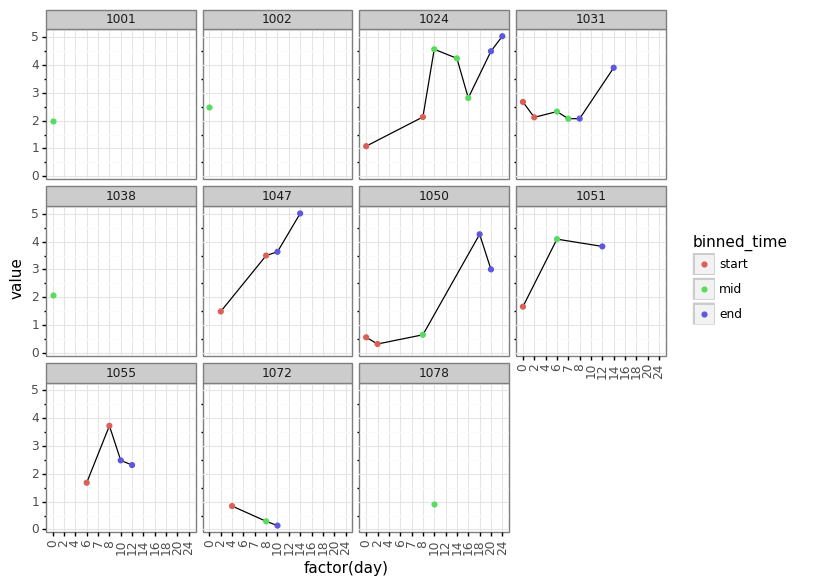

<ggplot: (8792417531357)>


In [67]:
plotdf = df.groupby(['patientID_415-xxxx', 'binned_time','day']).mean().dropna().reset_index()
plotdf = pd.melt(plotdf, id_vars=['patientID_415-xxxx','binned_time','day'])
plotdf['binned_time'] = (plotdf['binned_time']
                      .astype(str)
                      .astype(CategoricalDtype(['start','mid','end']))
                     )
plotdf = plotdf.rename(columns={'patientID_415-xxxx':'patient'})

plotnine.options.figure_size = (8,8)
plot = (ggplot(plotdf)
        + theme_bw()
        + theme(aspect_ratio=1,
                axis_text_x = element_text(angle = 90)
               )
        + geom_line(aes('factor(day)','value',group='patient'))
        + geom_point(aes('factor(day)','value',color='binned_time'))
        + facet_wrap('~patient', ncol=4)
       )
print(plot)